# PSIS-LOO on Hard Nonlinear / Abrupt-Change Data (Prior Misspec)

급격한 변동/강한 비선형 + prior가 빗나간 상황에서 credible 구간과 PSIS-LOO Conformal 구간을 비교합니다.
모델: (1) 공액 BLR(강한 수축 prior), (2) BART(얕은 트리 prior). Pareto k 진단도 함께 보고합니다.

In [1]:
# Repo import path
import sys
from pathlib import Path
repo_root = Path.cwd()
if (repo_root / 'examples').exists() and (repo_root / 'bartpy').exists():
    pass
elif (repo_root.name == 'examples') and (repo_root.parent / 'bartpy').exists():
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))
print('Repo root:', repo_root)

Repo root: c:\Users\KIMJUNHEE\Documents\GitHub\bartpy


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from bartpy.sklearnmodel import SklearnModel
from bartpy import (
    prepare_bart_loglik_and_draws,
    loo_residuals_via_psis,
    conformal_quantile,
    build_intervals,
)
from examples.bayes_linreg import (
    posterior_draws_and_loglik,
    posterior_draws_loglik_and_pred,
)

In [3]:
# Hard nonlinear + abrupt-change data with heavy-tailed, heteroscedastic noise
rng = np.random.default_rng(2025)
n = 350
X = rng.uniform(-3.0, 3.0, size=(n, 1))
x1 = X[:, 0]
# Base nonlinear part
f_true = np.sin(2.5*x1) + 0.4*np.sin(8*x1)
# Abrupt changes via tanh steps (approximate jump)
f_true += 1.2*np.tanh(6*(x1 - 0.7)) - 1.0*np.tanh(6*(x1 + 0.6))
# Heteroscedastic, heavy-tailed noise (t_3)
noise_scale = 0.18 + 0.12*(np.abs(x1)>1.2) + 0.08*(x1>0)
eps = rng.standard_t(3, size=n) * noise_scale
y = f_true + eps
# Quick view of data shape
X[:3], y[:3]

(array([[ 2.96674683],
        [-0.70794155],
        [ 1.96288808]]),
 array([ 1.51907129, -1.53307907, -0.89490277]))

## 1) BLR with strong shrinkage prior (misspecified)

In [4]:
# BLR posterior with very small tau2 (strong shrinkage to 0)
y_obs_blr, f_blr, loglik_blr, ypred_blr = posterior_draws_loglik_and_pred(
    X, y, S=1000, tau2=1e-3, a0=2.0, b0=1.0, seed=11
)
# Credible 90% from posterior predictive draws
lo_cr_blr = np.percentile(ypred_blr, 5, axis=1)
hi_cr_blr = np.percentile(ypred_blr, 95, axis=1)
cov_cr_blr = np.mean((y_obs_blr >= lo_cr_blr) & (y_obs_blr <= hi_cr_blr))
# PSIS-LOO residuals -> conformal q
res_blr, k_blr, loo_blr = loo_residuals_via_psis(y_obs_blr, f_blr, loglik_blr)
q_blr = conformal_quantile(res_blr, alpha=0.1)
lo_psis_blr, hi_psis_blr = build_intervals(loo_blr, q_blr)
cov_psis_blr = np.mean((y_obs_blr >= lo_psis_blr) & (y_obs_blr <= hi_psis_blr))
print(f'BLR credible 90%: cov={cov_cr_blr:.3f}')
print(f'BLR PSIS    90%: cov={cov_psis_blr:.3f}, Pareto k max={np.nanmax(k_blr):.3f}')

BLR credible 90%: cov=0.926
BLR PSIS    90%: cov=0.903, Pareto k max=1.553


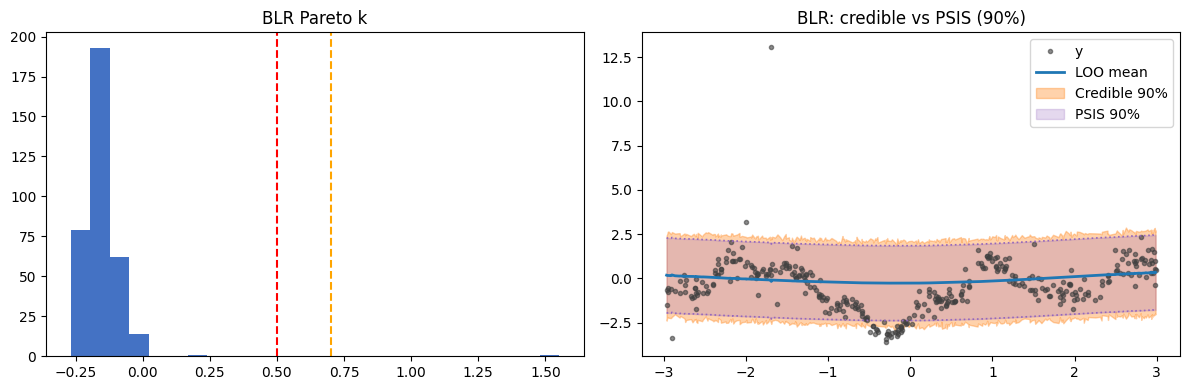

In [5]:
# BLR plots: Pareto k and overlaid intervals
fig, axes = plt.subplots(1, 2, figsize=(12,4))
# Pareto k
axes[0].hist(k_blr[np.isfinite(k_blr)], bins=25, color='#4472c4')
axes[0].axvline(0.5, color='r', ls='--'); axes[0].axvline(0.7, color='orange', ls='--')
axes[0].set_title('BLR Pareto k')
# Overlay
order = np.argsort(X[:,0]); x = X[order,0]
axes[1].plot(x, y_obs_blr[order], 'o', ms=3, color='0.25', alpha=0.6, label='y')
axes[1].plot(x, loo_blr[order], color='#1f77b4', lw=2, label='LOO mean')
axes[1].fill_between(x, lo_cr_blr[order], hi_cr_blr[order], color='#ff7f0e', alpha=0.35, label='Credible 90%')
axes[1].fill_between(x, lo_psis_blr[order], hi_psis_blr[order], color='#9467bd', alpha=0.25, label='PSIS 90%')
axes[1].plot(x, lo_psis_blr[order], color='#9467bd', ls=':', lw=1.2)
axes[1].plot(x, hi_psis_blr[order], color='#9467bd', ls=':', lw=1.2)
axes[1].set_title('BLR: credible vs PSIS (90%)')
axes[1].legend()
plt.tight_layout(); plt.show()

## 2) BART with shallow-tree prior (misspecified)

In [6]:
# BART: fewer trees + shallow prior to encourage underfitting
model = SklearnModel(
    n_trees=25, n_chains=2, n_samples=300, n_burn=300, thin=0.5,
    alpha=0.85, beta=5.0,
    store_in_sample_predictions=True, store_acceptance_trace=True, n_jobs=1,
)
model.fit(X, y)
# Prepare PSIS inputs from in-sample samples
y_obs_bt, f_bt, loglik_bt = prepare_bart_loglik_and_draws(model)
# Credible intervals via Gaussian noise with per-sample sigma
S = f_bt.shape[1]
sigma_s = np.array([m.sigma.current_unnormalized_value() for m in model._model_samples])
ypred_bt = f_bt + np.random.default_rng(1234).normal(size=f_bt.shape) * sigma_s[None, :]
lo_cr_bt = np.percentile(ypred_bt, 5, axis=1)
hi_cr_bt = np.percentile(ypred_bt, 95, axis=1)
cov_cr_bt = np.mean((y_obs_bt >= lo_cr_bt) & (y_obs_bt <= hi_cr_bt))
# PSIS-LOO residuals -> conformal
res_bt, k_bt, loo_bt = loo_residuals_via_psis(y_obs_bt, f_bt, loglik_bt)
q_bt = conformal_quantile(res_bt, alpha=0.1)
lo_psis_bt, hi_psis_bt = build_intervals(loo_bt, q_bt)
cov_psis_bt = np.mean((y_obs_bt >= lo_psis_bt) & (y_obs_bt <= hi_psis_bt))
print(f'BART credible 90%: cov={cov_cr_bt:.3f}')
print(f'BART PSIS    90%: cov={cov_psis_bt:.3f}, Pareto k max={np.nanmax(k_bt):.3f}')

Starting burn


100%|██████████| 300/300 [00:00<00:00, 321.05it/s]


Starting sampling


100%|██████████| 300/300 [00:01<00:00, 299.17it/s]


Starting burn


100%|██████████| 300/300 [00:00<00:00, 319.71it/s]


Starting sampling


100%|██████████| 300/300 [00:01<00:00, 281.59it/s]


BART credible 90%: cov=0.966
BART PSIS    90%: cov=0.903, Pareto k max=6.477


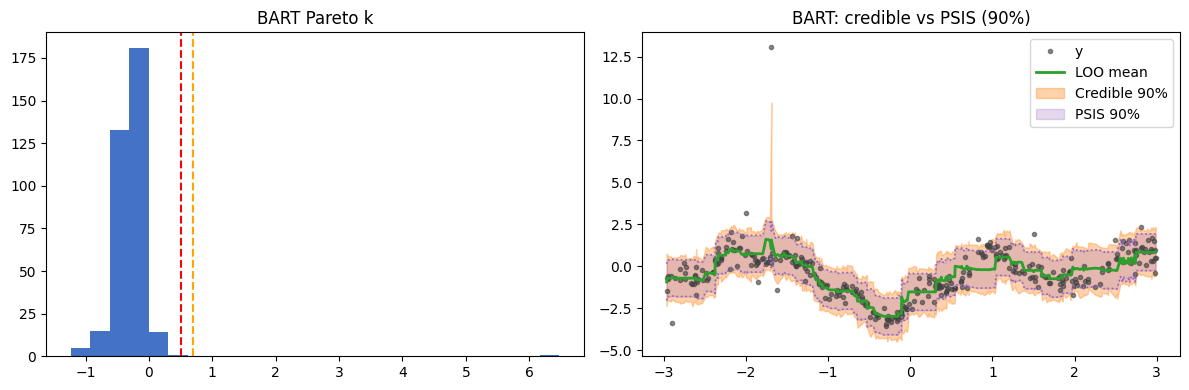

In [7]:
# BART plots: Pareto k and overlaid intervals
fig, axes = plt.subplots(1, 2, figsize=(12,4))
# Pareto k
axes[0].hist(k_bt[np.isfinite(k_bt)], bins=25, color='#4472c4')
axes[0].axvline(0.5, color='r', ls='--'); axes[0].axvline(0.7, color='orange', ls='--')
axes[0].set_title('BART Pareto k')
# Overlay
order = np.argsort(X[:,0]); x = X[order,0]
axes[1].plot(x, y_obs_bt[order], 'o', ms=3, color='0.25', alpha=0.6, label='y')
axes[1].plot(x, loo_bt[order], color='#2ca02c', lw=2, label='LOO mean')
axes[1].fill_between(x, lo_cr_bt[order], hi_cr_bt[order], color='#ff7f0e', alpha=0.35, label='Credible 90%')
axes[1].fill_between(x, lo_psis_bt[order], hi_psis_bt[order], color='#9467bd', alpha=0.25, label='PSIS 90%')
axes[1].plot(x, lo_psis_bt[order], color='#9467bd', ls=':', lw=1.2)
axes[1].plot(x, hi_psis_bt[order], color='#9467bd', ls=':', lw=1.2)
axes[1].set_title('BART: credible vs PSIS (90%)')
axes[1].legend()
plt.tight_layout(); plt.show()